## Try Bert Model for single Dx of ASD...

In [1]:
import tensorflow as tf, numpy as np, pandas as pd
tf.__version__

'2.8.2'

In [2]:
df=pd.read_csv('NLP22355_ASD.csv')
df.tail(2)

C:\Users\sam\AppData\Local\Temp/ipykernel_6912/2749842556.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('NLP22355_ASD.csv')


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,SNO,病歷號,身份證號,出生年,出生月,出生日,到院年,...,age,軍人,思覺失調,憂鬱症,人格疾患,適應障礙,躁症,物質使用,ADHD,ASD
22353,22353,24624,24624,26224.0,137214,R220493026,66,1,1,95,...,29.25,0,0,1,0,0,0,0,0,0
22354,22354,24625,24625,26225.0,120459,R123517601,72,11,15,94,...,21.75,0,1,0,0,0,0,0,0,0


In [3]:
y1=df['ADHD'].to_numpy().reshape(-1,1)
y2=df['ASD'].to_numpy().reshape(-1,1)
yt=tf.concat([y1,y2],axis=1)
yt

<tf.Tensor: shape=(22355, 2), dtype=int64, numpy=
array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int64)>

In [4]:
x_list=df['現在病史'].values.tolist()
x_list[-1]

'個案病前人格內向，少友，五專三年級肄業。在校成績中上，否認有在學期間有蹺課、打架遭記過之記錄，也否認有任何前科、頭部外傷或藥物濫用等記錄。個案於五專三年級時（MK91），出現喃喃自語（疑似幻聽干擾）、個案會有聽到腦中思考的想法會變成聲音的干擾，個案感到很煩躁、不安，無法專心功課及人際互動，因此功課及人際功能逐漸變差，因此家人帶個案去廟宇求助及醫院精神科就診，當時診斷為精神分裂症，並服藥門診追蹤，但上述症狀，仍未改善，且個案容易有四肢僵硬、煩躁、手抖、不斷來回走動等不舒服症狀，個案時有因受干擾而心煩，會想摔東西，入睡前會聽到耳邊有聲音干擾，平時也認為報紙及電視會報導個案之故事的關係妄想。因此於MK91-11改至本院門診就診。之後副作用症狀逐漸減輕，也能於本院規則門診追蹤，但精神症狀仍未完全改善，此外平日個案之自我照顧功能在家人照顧下尚可。94-3月個案不斷出現情緒焦慮、煩躁、不斷喃喃自語、在屋內來一直重複回走動、出現日夜生活顛倒、夜眠差、對家人語言攻擊、以致由家屬帶至本院住院，94-4出院後尚可規則門診追蹤服藥。但根據家屬表示個案最近一週個案於家中出現踱步，情緒不穩定，自言自語，並有關係妄想等情形，故由家人帶至本院就診。'

## BERT transformer

In [5]:
import bert, tensorflow_hub as hub
BertTokenizer=bert.bert_tokenization.FullTokenizer
bert_layer=hub.KerasLayer('bert_zh_L-12_H-768_A-12_2',trainable=False)
vocabulary_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case=bert_layer.resolved_object.do_lower_case.numpy()
tokenizer=BertTokenizer(vocabulary_file,to_lower_case)
def tokenize_text(text_input):
    myText=''
    try:
        myText=tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_input))
    except:
        myText='NaN'
    return myText

In [6]:
x_tokenized=[]
for i in x_list:
    x_tokenized.append(tokenize_text(i))
type(x_tokenized) ##list

list

In [7]:
len(x_tokenized) ##22355
type(x_tokenized) ##list
##x_tokenized[-1]

list

In [9]:
max_length=768
x_trim=[]
for j in x_tokenized:
    x_trim.append(j[:max_length])
len(x_trim)##22355
len(x_trim[-1]) ##508

508

In [10]:
x_padded=[]
for k in x_trim:
    x_padded.append(k+[0]*(max_length-len(k)))
    
len(x_padded) ##22355\
len(x_padded[-1]) #768

768

In [11]:
x_tensor=tf.convert_to_tensor(x_padded)
x_tensor=tf.cast(x_tensor,tf.int32)

## REAL MODEL (Multiple layers)

In [16]:
class TEXTMODEL1(tf.keras.Model):
    def __init__(self):
        super(TEXTMODEL1, self).__init__()
        self.embedding=tf.keras.layers.Embedding(21128,100,input_length=768)
        self.myFlatten=tf.keras.layers.Flatten()
        self.myOutput=tf.keras.layers.Dense(2,activation='sigmoid')
        
    def call(self,inputs):       
        outputs=inputs
        outputs=self.embedding(outputs)
        outputs=self.myFlatten(outputs)
        outputs=self.myOutput(outputs)
        return outputs

## BERT + CNN model

In [23]:
cnn_filters=100
class TEXTMODEL(tf.keras.Model):
    def __init__(self):
        super(TEXTMODEL,self).__init__()
        self.myEmbedding=tf.keras.layers.Embedding(21128,768)
        self.myFlatten=tf.keras.layers.Flatten()
        self.cnn1=tf.keras.layers.Conv1D(filters=cnn_filters,kernel_size=2,padding='valid',activation='relu')
        self.cnn2=tf.keras.layers.Conv1D(filters=cnn_filters,kernel_size=3,padding='valid',activation='relu')
        self.cnn3=tf.keras.layers.Conv1D(filters=cnn_filters,kernel_size=4,padding='valid',activation='relu')
        self.pool=tf.keras.layers.GlobalMaxPool1D()
        self.dense=tf.keras.layers.Dense(units=100, activation='relu')
        self.dropout=tf.keras.layers.Dropout(rate=0.2)
        self.mySigmoid=tf.keras.layers.Dense(2,activation='sigmoid')
    
    def call(self,inputs):
        outputs=self.myEmbedding(inputs)
        ##outputs=self.myFlatten(outputs)
        l_1=self.cnn1(outputs)
        l_1=self.pool(l_1)
        l_2=self.cnn2(outputs)
        l_2=self.pool(l_2)
        l_3=self.cnn3(outputs)
        l_3=self.pool(l_3)
        outputs=tf.concat([l_1,l_2,l_3],axis=-1)
        outputs=self.mySigmoid(outputs)
        return outputs

In [24]:
myModel=TEXTMODEL()
myModel.build(input_shape=())
myModel.summary()

Model: "textmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  0 (unused)
                                                                 
 flatten_2 (Flatten)         multiple                  0 (unused)
                                                                 
 conv1d (Conv1D)             multiple                  0 (unused)
                                                                 
 conv1d_1 (Conv1D)           multiple                  0 (unused)
                                                                 
 conv1d_2 (Conv1D)           multiple                  0 (unused)
                                                                 
 global_max_pooling1d (Globa  multiple                 0 (unused)
 lMaxPooling1D)                                                  
                                                         

## TESTing MODEL (Single Layer)

In [28]:
myModel_=TEXTMODEL()
inputs=tf.Tensor(shape=(22355, 768), dtype=tf.int32)
outputs=myModel_(inputs)
MYMODEL=tf.keras.Model(inputs=inputs, outputs=outputs)


TypeError: __init__() got an unexpected keyword argument 'shape'

In [25]:
Result_pass=myModel(x_tensor)
Result_pass

ResourceExhaustedError: Exception encountered when calling layer "embedding_2" (type Embedding).

OOM when allocating tensor with shape[22355,768,768] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:ResourceGather]

Call arguments received:
  • inputs=tf.Tensor(shape=(22355, 768), dtype=int32)

## Training Model

In [26]:
myModel.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_accuracy'])
history=myModel.fit(x=x_tensor,y=yt,
                    validation_split=0.3, 
                    epochs=2,batch_size=16)

Epoch 1/2
978/978 [==============================] - 564s 576ms/step - loss: 7.0141 - categorical_accuracy: 0.5081 - val_loss: 7.1380 - val_categorical_accuracy: 0.5611
Epoch 2/2
978/978 [==============================] - 576s 589ms/step - loss: 42.5151 - categorical_accuracy: 0.5034 - val_loss: 21.7902 - val_categorical_accuracy: 0.6882


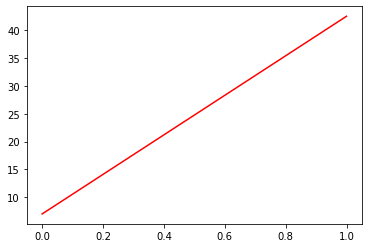

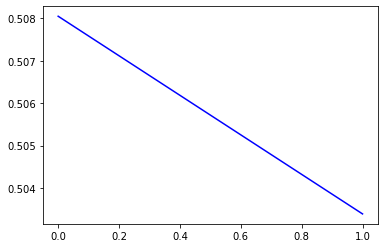

In [34]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'],'r')
plt.show()
plt.plot(history.history['categorical_accuracy'],'b')
plt.show()

### 使用dataset是不推薦的.....

In [ ]:
x_tuple=[]
for i in range(len(x_tokenized)):
    x_tuple.append(tuple(map(int,list(x_tokenized[i]))))
x_tuple[-1]                   

In [ ]:
x_dataset=tf.data.Dataset.from_generator(lambda: x_tuple,
                                         output_types=(tf.int32))
for a in x_dataset.take(1):
    print(a)

In [ ]:
x_padded=x_dataset.padded_batch(1,padded_shapes=((768)))
for b in x_padded.take(1):
    print(b)

In [ ]:
type(x_padded) ##tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset
x_padded.numpy()